<center> <h1>Homework 5 | DATA 5600</h1> </center>
<center> <h2>Multiple Linear Regression Variable Selection Methods</h2> </center>
<center> <h3> Dallin Moore <h3> </center>

In [117]:
# load packages here
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LinearRegression

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

# set seed
import random
random.seed(5600)

# suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Data and Description

**For this assignment, we are revisiting the data set used in Homework 4. I think it would be very beneficial for you to review your Homework 4 before starting this one.**

Measuring body fat is not simple. One method requires submerging the body underwater in a tank and measuring the increase in water level. A simpler method for estimating body fat would be preferred. In order to develop such a method, researchers recorded age (years), weight (pounds), height (inches), and three body circumference measurements (around the neck, chest, and abdominal (all in centimeters)) for 252 men. Each mans' percentage of body fat was accurately estimated by an underwater weighing technique (the variable brozek is the percentage of body fat). The hope is to be able to use this data to create a model that will accurately predict body fat percentage, by using just the basic variables recorded, without having to use the tank submerging method.

The data can be found in the BodyFat data set on Canvas. Download BodyFat.txt, and put it in the same folder as this file.

#### 0. Replace the text "\< YOUR NAME HERE \>" (above) with your full name.

#### 0b. Note that we set a seed in the setup code chunk above seed since some of the functions randomly split the data, and we want your code to be reproducible. Feel free to change the value from 5600, if you'd like.

#### 1. Read in the data set, and call the data frame "bodyfat_orig". Print a summary of the data and make sure the data makes sense. **Remove the "row" column (which contains row numbers) from the data set.** Make sure the class of "bodyfat_orig" is a Pandas dataframe. [2 points]

In [118]:
# Read in the data set
bodyfat_orig = pd.read_csv('BodyFat.txt', sep=' ')

# Remove the "row" column
bodyfat_orig = bodyfat_orig.drop(columns=['row'])

# Ensure the class of "bodyfat_orig" is a Pandas dataframe
print(type(bodyfat_orig))

bodyfat_orig.describe()

<class 'pandas.core.frame.DataFrame'>


,brozek,age,weight,height,neck,chest,abdom
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,18.889243,44.864542,178.828486,70.320717,37.983267,100.768526,92.494024
std,7.726733,12.623057,29.408329,2.606382,2.431748,8.400762,10.759625
min,0.000000,22.000000,118.500000,64.000000,31.100000,79.300000,69.400000
25%,12.800000,35.500000,158.750000,68.375000,36.400000,94.300000,84.550000
50%,19.000000,43.000000,176.250000,70.000000,38.000000,99.600000,90.900000
75%,24.550000,54.000000,196.875000,72.250000,39.400000,105.300000,99.200000
max,45.100000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000


#### 2. Refer back to your Homework 4. In that assignment, you fit a multiple linear regression model to this data set. For each of the multiple linear regression assumptions listed below, state if they were met or not met. [1 point] 

1. The X’s vs Y are linear: The relationship is mostly linear but there is an outlier value. High values of some predictors (neck, weight, chest, abdomen) are associated with unexpectedly low values of the dependent variable (percentage of body fat).
2. The residuals are normally distributed and centered at zero: The assumption is met based on the histogram, boxplot, and Q-Q plot, although the Shapiro-Wilks Test has a p-value greater than 0.05, meaning we fail to reject the null hypothesis.
3. The residuals are homoscedastic: The assumption is met based on the residuals vs. fitted values test.
4. The model describes all observations (i.e., there are no influential points): The assumption is not met based on many values being above the line in DFFITS/DFBETAS and one value being extra large.
5. No multicollinearity: The assumption is not met, the VIF value for weight is incredible high with abdomen and chest being relatively high.

#### 3. There is one clear influential point in the data set. Create a new variable called "bodyfat" that contains the bodyfat_orig data set with the influential point removed. Use the bodyfat data set (not the bodyfat_orig data set) throughout the rest of the assignment.  [1 point]

In [119]:
bodyfat = bodyfat_orig.drop(index=39)

### You should have discovered, from Homework 4, that there is a multicollinearity problem. The goal of this assignment is to continue this analysis by identifying variables to potentially remove from the model to resolve the multicollinearity issues.

#### 4. Briefly explain why multicollinearity is a problem for multiple linear regression by identifying two consequences of multicollinearity. [2 points]

Multicollinearity is a problem for multiple linear regression because it can lead to **Inflated Standard Errors** and **Unstable Coefficients.** 

When predictor variables are highly correlated, it becomes difficult to determine the individual effect of each predictor on the response variable. This results in inflated standard errors for the regression coefficients, making it harder to determine which predictors are significant.

Multicollinearity can also cause the  coefficients to be highly sensitive to changes in the model. Small changes in the data can lead to large changes in the estimated coefficients, making the model unreliable and difficult to interpret.

#### 5. Briefly explain the similarities and differences between the following methods: best subset, forward, backward, and sequential replacement. Do not just copy the algorithm from the class notes - use your own words to explain what these methods are doing. [3 points]

Best subset selection involves evaluating all possible combinations of predictor variables to find the model that best fits the data based on a chosen criterion (AIC, BIC). 

Forward selection starts with no predictors in the model and adds them one by one. At each step, the predictor that improves the model the most (based on a chosen criterion) is added. This ends when no significant improvement can be made. (Worst option.)

Backward selection starts with all candidate predictors in the model and removes them one by one. At each step, the predictor that contributes the least to the model (based on a chosen criterion) is removed. This process ends when all remaining predictors are significant.

Sequential replacement is a combination of forward and backward selection. It starts with either an empty model or a full model and adds/removes predictors based on their contribution to the model. With sequential, adding a predictor that was previously removed or removing a predictor that was previously added means more flexibility in ultimately finding the best model.

#### 6. Briefly explain how shrinkage methods work (mention the variance-bias tradeoff). [1 points]

Shrinkage methods work by putting a penalty on the size of the coefficients in a regression model. This helps to reduce the complexity of the model, which can lead to better generalization on new data. The main idea is to favor a small increase in bias (error introduced by approximating a real-world problem) for a large decrease in variance, which can result in a more accurate and stable model overall.

Shrinkage methods, add a regularization term to the loss function. Ridge Regression adds an L2 penalty (sum of the squared coefficients), LASSO adds an L1 penalty (sum of the absolute values of the coefficients), while Elastic Net combines both L1 and L2 penalties.

#### 7. Briefly explain the similarities/difference between ridge regression, LASSO, and elastic net. [2 points]

- **Ridge Regression**: Adds an L2 penalty (the sum of the squared coefficients) to the loss function. This shrinks the coefficients towards zero but does not set any of them exactly to zero, so no variables are removed. It's useful when all predictors are potentially important.

- **LASSO**: Adds an L1 penalty (the sum of the absolute values of the coefficients) to the loss function. This can shrink some coefficients to exactly zero, basically performing variable selection. It is useful when we expect only a few predictors to be important.

- **Elastic Net**: Combines both L1 and L2 penalties. It includes a mixing parameter that determines the relative contribution of the L1 and L2 penalties. This method is useful when there are multiple correlated predictors, as it can select groups of correlated variables. Works best with high multicollinearity.

#### 8. When coding these methods, the response variable must be separated from the predictor variables. Previously, you have added a constant with `sm.add_constant(X)` to include the intercept when used with the `sm.OLS` function. Here, you will not need to add the intercept since sklearn's `LinearRegression` model has a built-in parameter that let's you specify if the intercept is included or not (it should be included). Split the data into response variable `y` (brozek) and predictor variables `X` to use an sklearn model. [1 point]

In [120]:
# Split the data into response variable y and predictor variables X
y = bodyfat[['brozek']]
X = bodyfat.drop('brozek', axis = 1)

# Print the shapes to verify
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (250, 6)
Shape of y: (250, 1)


#### 9. Apply the best subsets variable selection procedure from `mlxtend` to this data set. Use the (negative) PMSE as the selection criteria metric with cv = 5. Explore different models and write down the variable names you would include in a model based on this method. Explain your reasoning. [2 points]

In [121]:
# Apply the best subsets variable selection procedure
best_subsets_selection = EFS(estimator=LinearRegression(), 
                             min_features=1,
                             max_features=len(X.columns),
                             scoring='neg_mean_squared_error',
                             print_progress=False,
                             cv=5)

best_subsets = best_subsets_selection.fit(X, y)

# Print the best subset of features
print('Best subset:', best_subsets.best_feature_names_)

Best subset: ('weight', 'neck', 'abdom')


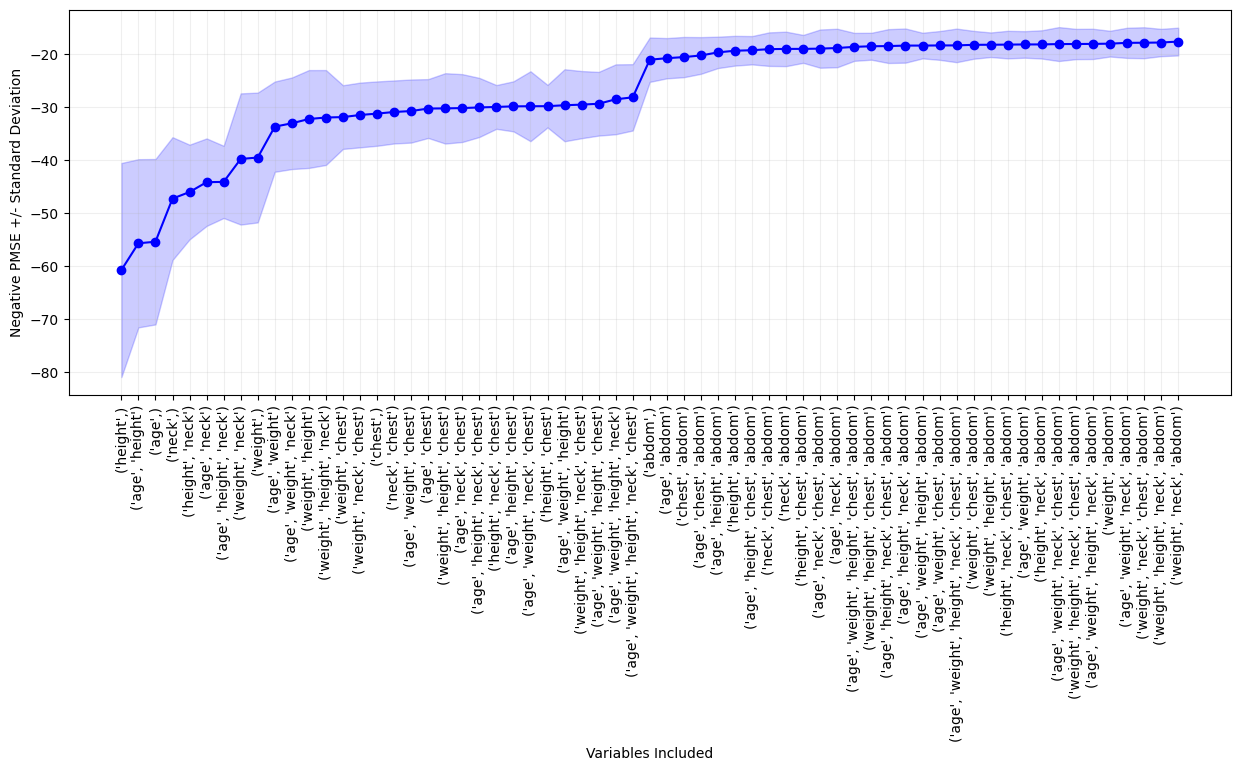

In [122]:
metric_dict = best_subsets_selection.get_metric_dict()
x_axis = sorted(metric_dict.keys())

metric_dict_sorted = dict(sorted(metric_dict.items(), key = lambda x: x[1]['avg_score']))

fig = plt.figure(figsize = (15, 5))
k_feat = metric_dict_sorted.keys()
k_feat_list = list(k_feat)
avg = [metric_dict_sorted[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict_sorted[k]['avg_score'] +
                 metric_dict_sorted[k]['std_dev'])
    lower.append(metric_dict_sorted[k]['avg_score'] -
                 metric_dict_sorted[k]['std_dev'])
    
plt.fill_between(x_axis,
                 upper,
                 lower,
                 alpha = 0.2,
                 color = 'blue',
                 lw = 1)

plt.plot(x_axis, avg, color = 'blue', marker = 'o')
plt.ylabel('Negative PMSE +/- Standard Deviation')
plt.xlabel('Variables Included')
plt.xticks(x_axis, 
           [str(metric_dict_sorted[k]['feature_names']) for k in k_feat_list], 
           rotation = 90)
plt.grid(alpha = 0.2)
plt.show()

In [123]:
# Code to see the next best models
best_subsets_results = pd.DataFrame.from_dict(best_subsets_selection.get_metric_dict()).T
best_subsets_results_sorted = best_subsets_results.sort_values(by='avg_score', ascending=False)
best_subsets_results_sorted[(best_subsets_results_sorted['avg_score'] > -20) & (best_subsets_results_sorted['std_dev'] < 2.6)]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
52,"(1, 2, 3, 5)","[-19.91724660109238, -15.144665592592455, -18....",-17.817056,"(weight, height, neck, abdom)",3.309671,2.575036,1.287518
14,"(1, 5)","[-19.572100674811374, -15.93291248780029, -18....",-18.03127,"(weight, abdom)",3.12151,2.428641,1.214321
24,"(0, 1, 5)","[-19.55737235415457, -16.06638375626067, -18.7...",-18.180421,"(age, weight, abdom)",3.215727,2.501945,1.250972
33,"(1, 2, 5)","[-20.074668060553186, -15.86155509067219, -18....",-18.236791,"(weight, height, abdom)",2.9765,2.315818,1.157909
43,"(0, 1, 2, 5)","[-20.084845174580263, -16.007214823141833, -18...",-18.392437,"(age, weight, height, abdom)",3.106807,2.417201,1.208601
53,"(1, 2, 4, 5)","[-20.60663501564025, -15.997997443607083, -18....",-18.519516,"(weight, height, chest, abdom)",3.261802,2.537793,1.268896


With the graph, it's clear that there are a lot of combinations that could be used. Any of the subsets with an `avg_score` of greater than -20 is good option or that contains `abdom` (as all subsets that contain `abdom` have an average score of greater than -20). To further reduce the amount of subsets to consider, the above table only looks at options with a standard deviation of less than 2.6. Given this, `weight` should also be included.

#### 10. Apply the forward selection procedure using `mlxtend` to this data set. Use the (negative) PMSE as the selection criteria metric with cv = 5. Explore different models and write down the variable names you would include in a model based on this method. Explain your reasoning. [2 points]

In [124]:
forward_selection = SFS(LinearRegression(fit_intercept = True), 
                        k_features = (1, len(X.columns)), 
                        forward = True, 
                        floating = False,
                        scoring = 'neg_mean_squared_error',
                        cv = 5)

forward = forward_selection.fit(X, y)

print('Forward Stepwise Selection:', forward.k_feature_names_)

Forward Stepwise Selection: ('weight', 'neck', 'abdom')


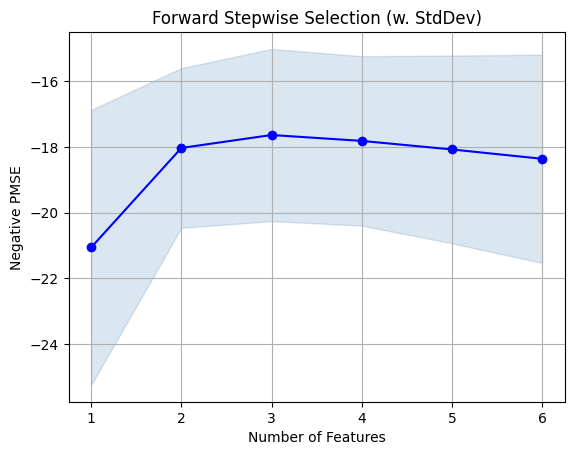

In [125]:
# Code to plot the (negative) PMSEs
fig1 = plot_sfs(forward.get_metric_dict(), kind = 'std_dev')
plt.title('Forward Stepwise Selection (w. StdDev)')
plt.ylabel("Negative PMSE")
plt.grid()
plt.show()

In [126]:
# Code to see the next best models
forward_results = pd.DataFrame.from_dict(forward_selection.get_metric_dict()).T
forward_results_sorted = forward_results.sort_values(by = 'avg_score', ascending = False)
forward_results_sorted 

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(1, 3, 5)","[-19.271875962025707, -15.370794774690197, -18...",-17.638109,"(weight, neck, abdom)",3.363873,2.617208,1.308604
4,"(1, 2, 3, 5)","[-19.91724660109238, -15.144665592592455, -18....",-17.817056,"(weight, height, neck, abdom)",3.309671,2.575036,1.287518
2,"(1, 5)","[-19.572100674811374, -15.93291248780029, -18....",-18.03127,"(weight, abdom)",3.12151,2.428641,1.214321
5,"(0, 1, 2, 3, 5)","[-19.909871759499737, -15.26643198343276, -18....",-18.077121,"(age, weight, height, neck, abdom)",3.667426,2.853382,1.426691
6,"(0, 1, 2, 3, 4, 5)","[-20.374585038709117, -15.300132218517312, -18...",-18.360793,"(age, weight, height, neck, chest, abdom)",4.068542,3.165464,1.582732
1,"(5,)","[-28.917443202998726, -20.70561477747331, -18....",-21.055296,"(abdom,)",5.373306,4.180615,2.090307


Based on forward selection, (although it should never actually be used) the subset with variables `weight`, `neck`, and `abdom` should be used because they have the highest average score.

#### 11. Apply the backward selection procedure using `mlxtend` to this data set. Use the (negative) PMSE as the selection criteria metric with cv = 5. Explore different models and write down the variable names you would include in a model based on this method. Explain your reasoning. [2 points]

In [127]:
backward_selection = SFS(LinearRegression(fit_intercept = True), 
                         k_features = (1, len(X.columns)), 
                         forward = False, 
                         floating = False,
                         scoring = 'neg_mean_squared_error',
                         cv = 5)

backward = backward_selection.fit(X, y)

print('Backward Stepwise Selection:', backward.k_feature_names_)

Backward Stepwise Selection: ('weight', 'neck', 'abdom')


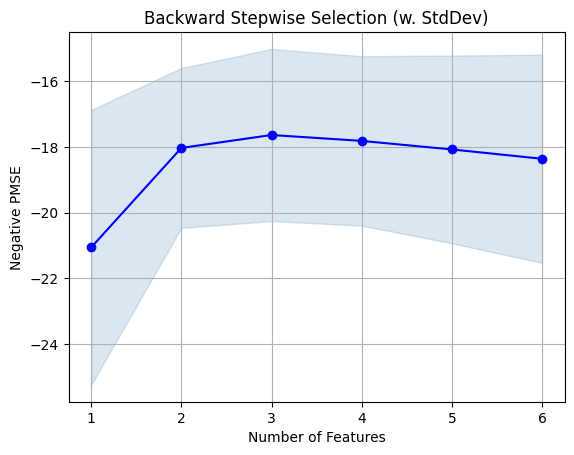

In [128]:
# Code to plot the (negative) PMSEs
fig1 = plot_sfs(backward.get_metric_dict(), kind = 'std_dev')
plt.title('Backward Stepwise Selection (w. StdDev)')
plt.ylabel("Negative PMSE")
plt.grid()
plt.show()

In [129]:
# Code to see the next best models
backward_results = pd.DataFrame.from_dict(backward.get_metric_dict()).T
backward_results_sorted = backward_results.sort_values(by = 'avg_score', ascending = False)
backward_results_sorted

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(1, 3, 5)","[-19.271875962025707, -15.370794774690197, -18...",-17.638109,"(weight, neck, abdom)",3.363873,2.617208,1.308604
4,"(1, 2, 3, 5)","[-19.91724660109238, -15.144665592592455, -18....",-17.817056,"(weight, height, neck, abdom)",3.309671,2.575036,1.287518
2,"(1, 5)","[-19.572100674811374, -15.93291248780029, -18....",-18.03127,"(weight, abdom)",3.12151,2.428641,1.214321
5,"(0, 1, 2, 3, 5)","[-19.909871759499737, -15.26643198343276, -18....",-18.077121,"(age, weight, height, neck, abdom)",3.667426,2.853382,1.426691
6,"(0, 1, 2, 3, 4, 5)","[-20.374585038709117, -15.300132218517312, -18...",-18.360793,"(age, weight, height, neck, chest, abdom)",4.068542,3.165464,1.582732
1,"(5,)","[-28.917443202998726, -20.70561477747331, -18....",-21.055296,"(abdom,)",5.373306,4.180615,2.090307


Based on the greatest average score, `weight`, `neck`, and `abdom` should be included using backward selection.

#### 12. Apply the sequential replacement selection procedure using `mlxtend` to this data set. Use the (negative) PMSE as the selection criteria metric with cv = 5. Explore different models and write down the variable names you would include in a model based on this method. Explain your reasoning. (Hint: `SequentialFeatureSelector` has a parameter called "floating" that will help you apply this procedure.) [2 points]

In [130]:
seqrep_selection = SFS(LinearRegression(fit_intercept = True), 
                                        k_features = (1, len(X.columns)), 
                                        forward = True, 
                                        floating = True,
                                        scoring = 'neg_mean_squared_error',
                                        cv = 5)

seqrep = seqrep_selection.fit(X, y)

print('Sequential Replacement Stepwise Selection:', seqrep.k_feature_names_)

Sequential Replacement Stepwise Selection: ('weight', 'neck', 'abdom')


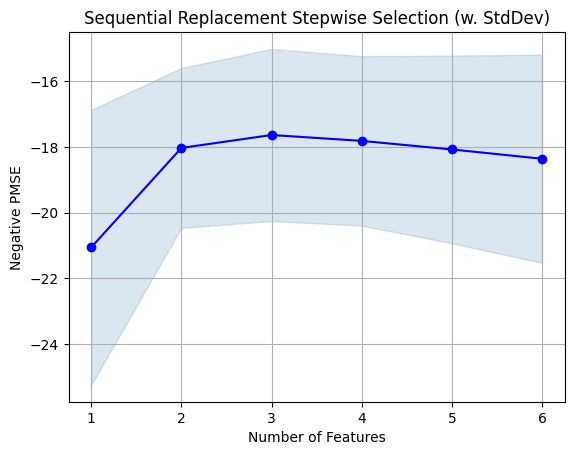

In [131]:
# Code to plot the (negative) PMSEs
fig1 = plot_sfs(seqrep.get_metric_dict(), kind = 'std_dev')
plt.title('Sequential Replacement Stepwise Selection (w. StdDev)')
plt.ylabel("Negative PMSE")
plt.grid()
plt.show()

In [132]:
# Code to see the next best models
seqrep_results = pd.DataFrame.from_dict(seqrep.get_metric_dict()).T
seqrep_results_sorted = seqrep_results.sort_values(by = 'avg_score', ascending = False)
seqrep_results_sorted

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(1, 3, 5)","[-19.271875962025707, -15.370794774690197, -18...",-17.638109,"(weight, neck, abdom)",3.363873,2.617208,1.308604
4,"(1, 2, 3, 5)","[-19.91724660109238, -15.144665592592455, -18....",-17.817056,"(weight, height, neck, abdom)",3.309671,2.575036,1.287518
2,"(1, 5)","[-19.572100674811374, -15.93291248780029, -18....",-18.03127,"(weight, abdom)",3.12151,2.428641,1.214321
5,"(0, 1, 2, 3, 5)","[-19.909871759499737, -15.26643198343276, -18....",-18.077121,"(age, weight, height, neck, abdom)",3.667426,2.853382,1.426691
6,"(0, 1, 2, 3, 4, 5)","[-20.374585038709117, -15.300132218517312, -18...",-18.360793,"(age, weight, height, neck, chest, abdom)",4.068542,3.165464,1.582732
1,"(5,)","[-28.917443202998726, -20.70561477747331, -18....",-21.055296,"(abdom,)",5.373306,4.180615,2.090307


Now using the Sequential Replacement method, once again the variables `weight`, `neck`, and `abdom` should be included based on the greatest average score.

#### 13. Apply LASSO using `sklearn` to this data set using the PMSE metric (`neg_mean_squared_error`) with cv = 5. Do the following: (a) Output the lambda (called alpha in the code) coefficient value corresponding to the 1 standard error rule, and (b) output the variable coefficient values resulting from LASSO with lambda equal to the value obtained in (a). [2 points]

In [133]:
# Standardize predictors
y = bodyfat['brozek'].ravel()
variable_names = X.columns
scaler = StandardScaler().fit(X[variable_names]) 
X[variable_names] = scaler.transform(X[variable_names])

In [134]:
# a) Output the lambda (called alpha in the code) coefficient value corresponding to the 1 standard error rule
# Create a list of possible alphas
potential_alphas = np.logspace(-4, 2, 500)
LASSOCV_model = LassoCV(alphas = potential_alphas, 
                        cv = 5, 
                        random_state = 12345, 
                        max_iter = 10000, 
                        fit_intercept = True)

# Fit the model
LASSOCV_model.fit(X, y)

# Get the list of alphas and corresponding MSEs
alphas = LASSOCV_model.alphas_
pmse_means = np.mean(LASSOCV_model.mse_path_, axis = 1)
pmse_std_error = np.std(LASSOCV_model.mse_path_, 
                        axis = 1,
                        ddof = 1) / np.sqrt(5)  # 5-fold CV

# Find the alpha that minimizes MSE
alpha_index_min = np.argmin(pmse_means)
alpha_min = alphas[alpha_index_min]

# Find the MSE that is one standard error away from the minimum MSE
one_se_above_min = min(pmse_means) + pmse_std_error[alpha_index_min]

# Find the largest alpha with MSE less than or equal to one_se_above_min
alpha_index_1se = np.where(pmse_means <= one_se_above_min)[0][0]
alpha_1se = alphas[alpha_index_1se]

print("Minimum alpha:", alpha_min)
print("One SE alpha:", alpha_1se)

Minimum alpha: 0.024030428944069697
One SE alpha: 0.4398317466650224


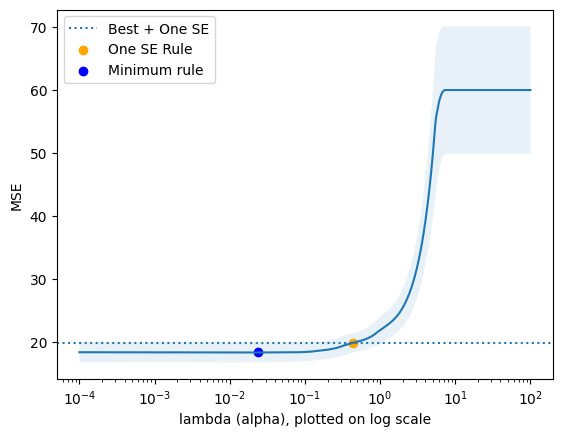

In [135]:
# Optional plot
plt.plot(alphas, 
         pmse_means)
plt.fill_between(alphas, 
                 pmse_means + pmse_std_error, 
                 pmse_means - pmse_std_error, 
                 alpha = 0.1)
plt.axhline(one_se_above_min, 
            linestyle = 'dotted', 
            label = 'Best + One SE')
plt.scatter([alpha_1se], 
            [pmse_means[alpha_index_1se]], 
            marker = 'o',
            color = 'orange', 
            label = 'One SE Rule')
plt.scatter([alpha_min],
            [pmse_means[alpha_index_min]],
            marker = 'o',
            color = 'blue',
            label = 'Minimum rule')
plt.legend()
plt.xscale('log')
plt.xlabel('lambda (alpha), plotted on log scale')
plt.ylabel('MSE')
plt.show()

In [136]:
# b) output the variable coefficient values resulting from LASSO with lambda equal to the value obtained in (a)
# LASSO results with lambda within one SE of the mean
LASSO_1se = Lasso(alpha = alpha_1se,
                   fit_intercept = True)
LASSO_1se.fit(X, y)

# Get coefficients
print("One SE alpha:",list(zip(LASSO_1se.coef_, X)))

# LASSO results with min(lambda)
LASSO_min = Lasso(alpha = alpha_min,
                   fit_intercept = True)
LASSO_min.fit(X, y)

# Get coefficients
print("Minimum alpha:",list(zip(LASSO_min.coef_, X)))

One SE alpha: [(0.1967853484454181, 'age'), (-0.0, 'weight'), (-0.836798028155446, 'height'), (-0.07111239608492964, 'neck'), (0.0, 'chest'), (5.962728592455219, 'abdom')]
Minimum alpha: [(0.0936861794866693, 'age'), (-2.0133675517489973, 'weight'), (-0.5218110151647195, 'height'), (-1.105006932856528, 'neck'), (0.0, 'chest'), (8.88969537274342, 'abdom')]


#### 14. Apply Elastic Net using `sklearn` to this data set using the PMSE metric (`neg_mean_squared_error`) with cv = 5. Do the following: (a) Output the lambda (called alpha in the code) coefficient value corresponding to the 1 standard error rule, and (b) output the variable coefficient values resulting from LASSO with lambda equal to the value obtained in (a). [2 points]

In [137]:
# (a) Output the lambda (called alpha in the code) coefficient value corresponding to the 1 standard error rule
# Create a list of possible alphas
potential_alphas = np.logspace(-4, 2, 500)

# run cross-validation to find the best alpha and l1_ratio
ElasticNetCV_model = ElasticNetCV(alphas = potential_alphas, 
                                  cv = 5, 
                                  random_state = 12345, 
                                  max_iter = 10000, 
                                  fit_intercept = True)
ElasticNetCV_model.fit(X, y)

# Get the list of alphas and corresponding MSEs
alphas = ElasticNetCV_model.alphas_
pmse_means = np.mean(ElasticNetCV_model.mse_path_, axis = 1)
pmse_std_error = np.std(ElasticNetCV_model.mse_path_, 
                        axis = 1,
                        ddof = 1) / np.sqrt(5)  # 5-fold CV

# Find the alpha that minimizes MSE
alpha_index_min = np.argmin(pmse_means)
alpha_min = alphas[alpha_index_min]

# Find the MSE that is one standard error away from the minimum MSE
one_se_above_min = min(pmse_means) + pmse_std_error[alpha_index_min]

# Find the largetst alpha with MSE less than or equal to one_se_above_min
alpha_index_1se = np.where(pmse_means <= one_se_above_min)[0][0]
alpha_1se = alphas[alpha_index_1se]

print("Minimum alpha:", alpha_min)
print("One SE alpha:", alpha_1se)

Minimum alpha: 0.0001
One SE alpha: 0.17158089856100048


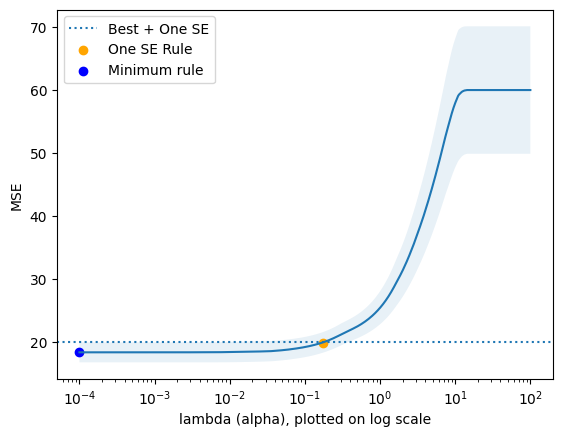

In [138]:
# Optional plot
plt.plot(alphas, 
         pmse_means)
plt.fill_between(alphas, 
                 pmse_means + pmse_std_error, 
                 pmse_means - pmse_std_error, 
                 alpha = 0.1)
plt.axhline(one_se_above_min, 
            linestyle = 'dotted', 
            label = 'Best + One SE')
plt.scatter([alpha_1se], 
            [pmse_means[alpha_index_1se]], 
            marker = 'o',
            color = 'orange', 
            label = 'One SE Rule')
plt.scatter([alpha_min],
            [pmse_means[alpha_index_min]],
            marker = 'o',
            color = 'blue',
            label = 'Minimum rule')
plt.legend()
plt.xscale('log')
plt.xlabel('lambda (alpha), plotted on log scale')
plt.ylabel('MSE')
plt.show()

In [139]:
# (b) output the variable coefficient values resulting from LASSO with lambda equal to the value obtained in (a)
# Elastic Net results with lambda within one SE of the mean
en_1se = ElasticNet(alpha = alpha_1se,
                     fit_intercept = True)
en_1se.fit(X, y)

# Get coefficients
print("One SE alpha:", list(zip(en_1se.coef_, X)))

# Elastic Net results with min(lambda)
en_min = ElasticNet(alpha = alpha_min,
                     fit_intercept = True)
en_min.fit(X, y)

# Get coefficients
print("Minimum alpha:", list(zip(en_min.coef_, X)))

One SE alpha: [(0.5126279245676796, 'age'), (0.0, 'weight'), (-0.9444818771688588, 'height'), (-0.6626793412180628, 'neck'), (0.877472554863988, 'chest'), (5.441456423166889, 'abdom')]
Minimum alpha: [(0.046971928812624, 'age'), (-2.4273425644478244, 'weight'), (-0.431071263630505, 'height'), (-1.100585400576355, 'neck'), (0.058551385340809003, 'chest'), (9.21436775935908, 'abdom')]


#### 15. Fill in the table below with "X"s (like the one at the end of the course notes: a row for each variable, a column for each variable selection method, an "X" in a cell means the variable was included for that variable selection method). *Fill it out according to the model you think is "best" for each variable selection method based on your analyses above.* This need not correspond to what the algorithm says is "best." [1 point]

In [150]:
selection_data = {'Best Subset':            ['', 'X', 'X', 'X', '', 'X'],
                  'Forward':                ['', 'X', '', 'X', '', 'X'],
                  'Backward':               ['', 'X', '', 'X', '', 'X'],
                  'Sequential Replacement': ['', 'X', '', 'X', '', 'X'],
                  'LASSO':                  ['X', 'X', 'X', 'X', 'X', 'X'],
                  'Elastic Net':            ['X', '', 'X', 'X', 'X', 'X']}

row_names = ['age', 'weight', 'height', 'neck', 'chest', 'abdom']

selection_table = pd.DataFrame(selection_data, index = row_names)
selection_table = selection_table.style.set_properties(**{'text-align': 'center'})
selection_table

,Best Subset,Forward,Backward,Sequential Replacement,LASSO,Elastic Net
age,,,,,X,X
weight,X,X,X,X,X,
height,X,,,,X,X
neck,X,X,X,X,X,X
chest,,,,,X,X
abdom,X,X,X,X,X,X


#### 16. Now that you have seen the various results from the different methods, pick a subset of variables that you will include in the model. Which variables do you choose to include in the model? Why? [1 point]

For the analysis, I will use `weight`, `abdom` and `neck` as they showed up the most with all of the tests and looking at the best subsets, `weight`, and `abdom` showed up very frequently.

#### 17. Create the multiple linear regression model using `sm.OLS` with the variables you listed in the previous question. Print a summary of the results. Save the residuals and fitted values from this model to the bodyfat dataframe. [1 point]

In [141]:
subset = ['weight', 'abdom', 'neck']
y = bodyfat[['brozek']]
X_subset = sm.add_constant(bodyfat[subset])
mod = sm.OLS(y, X_subset)
res = mod.fit()

bodyfat['residuals'] = res.resid
bodyfat['fittedvalues'] = res.fittedvalues

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 brozek   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     210.0
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           1.54e-67
Time:                        02:27:42   Log-Likelihood:                -705.45
No. Observations:                 250   AIC:                             1419.
Df Residuals:                     246   BIC:                             1433.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.5401      5.391     -5.850      0.000     -42.159     -20.922
weight        -0.1099      0.023     -4.843      0.000      -0.155      -0.065
abdom          0.9263      0.053     17.565      0.000       0.822       1.030
neck          -0.4100      0.192     -2.138      0.033      -0.788      -0.032
==============================================================================
Omnibus:                        3.754   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                2.528
Skew:                          -0.011   Prob(JB):                        0.283
Kurtosis:                       2.508   Cond. No.                     4.30e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Now that you have chosen a model, the next several questions ask you to check some of the model assumptions. For each assumption, (1) perform appropriate diagnostics to determine if the assumption is violated, and (2) explain whether or not you think the assumption is violated and why you think that. **Note: you can copy (then modify) a lot of your code from Homework 4 to answer these questions.**

#### 18. (L) The Xs vs Y are linear (use the partial regression plots) [2 points]

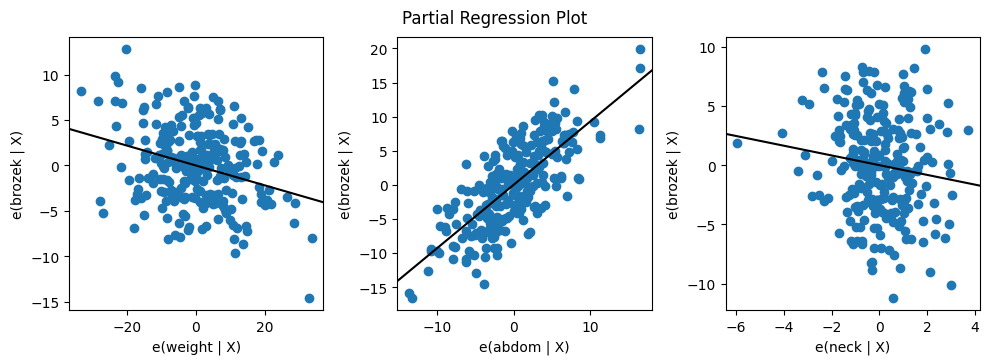

In [142]:
# partial regression plots
fig = plt.figure(figsize = (10,10))
sm.graphics.plot_partregress_grid(res, 
                                  exog_idx=subset, 
                                  grid=(3, 3), 
                                  fig=fig)
fig.tight_layout()
plt.show()

As we would expect after seeing how frequently `abdom` showed up in the selection methods, it has the strongest linear relationship. The next variable associated with a high lambda value was `weight` and it has the next highest correlation value. The correlation between `neck` and `brozek` is definitely the weakest, but that doesn't necessarily mean that it isn't linear.k But, all of the plots have a slope that isn't flat (zero) so there is definitely some relationship there. The assumption is met.

#### 19. (N) The residuals are normally distributed and centered at zero (use the boxplot and normal probability plot) [2 points]

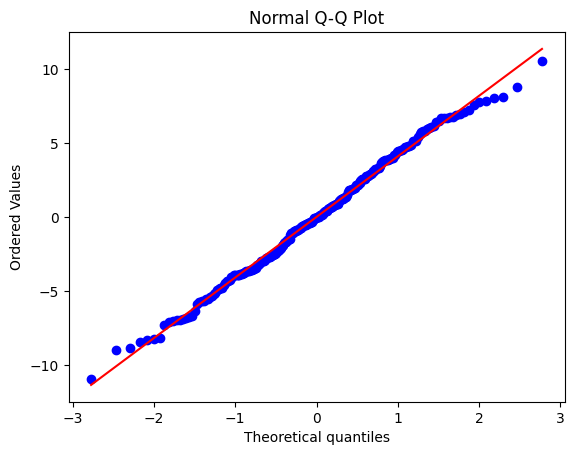

In [143]:
# Diagnostic 1 - Normality of Residuals
stats.probplot(res.resid, plot = plt)
plt.title("Normal Q-Q Plot")
plt.show()

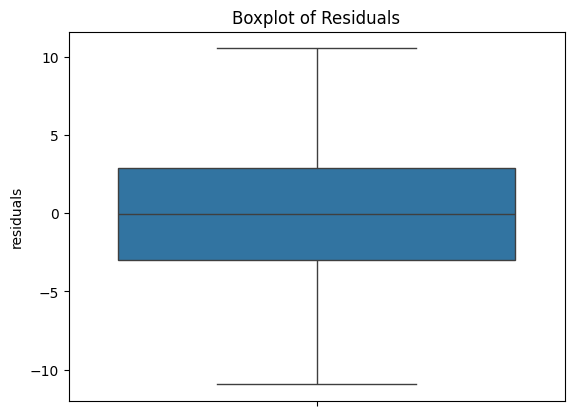

In [144]:
# Diagnostic 2 - Boxplot of Residuals
sns.boxplot(bodyfat['residuals'])
plt.title("Boxplot of Residuals")
plt.show()

Both the Q-Q Plot and the Boxplot of the residuals show that the residuals are normally distributed and centered at zero. The box plot makes this very clear; it's centered right at zero and doesn't have any outliers or skew in any direction. The Normal Probability plot has most of the dots right along the red line indicating their normal spread. The assumption is met.

#### 20. (E) The residuals have equal/constant variance across all values of X (use the residuals vs. fitted values plot) [2 points]

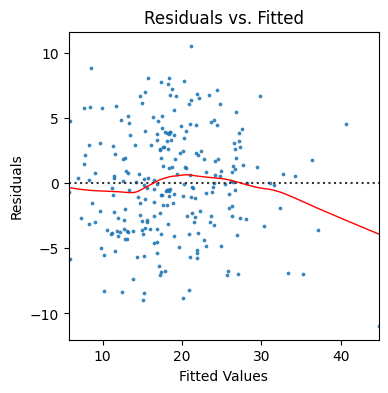

In [145]:
# Residuals vs. Fitted Values Plot
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = bodyfat['fittedvalues'], 
              y = bodyfat['residuals'],
              lowess = True,
              scatter_kws = {'s': 3},
              line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

The variance appear to mostly stay constant as the fitted values increase. The data is roughly homoscedastic and the assumption is met.

#### 21. (A) The model describes all observations (i.e., there are no influential points) (use the DFBETAS and DFFITS) [2 points]

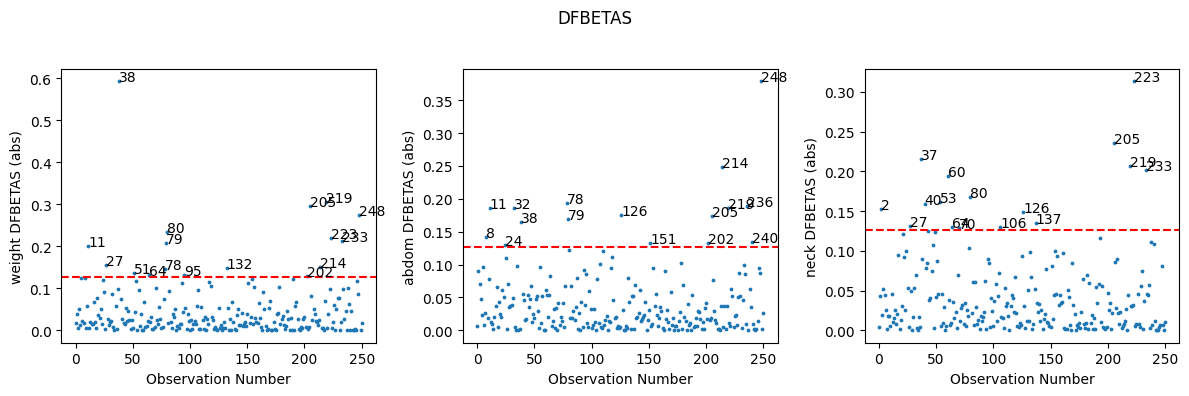

In [146]:
# DFBETAS 
def plot_dfbetas(column, ax, label_level=2 / np.sqrt(len(bodyfat))):
    idx = res.model.exog_names.index(column)
    # Calculate DFBETAS for the column
    bodyfat['dfbetas_' + column] = res.get_influence().dfbetas[:, idx]

    ax.set_ylabel(f"{column} DFBETAS (abs)")
    ax.set_xlabel("Observation Number")
    # Scatter plot of absolute DFBETAS values
    ax.scatter(bodyfat.index, np.abs(bodyfat['dfbetas_' + column]), s=3)
    # Horizontal line for cut-off
    ax.axhline(y=label_level, color='r', linestyle='dashed')

    # Optionally label the outliers
    outliers = bodyfat[np.abs(bodyfat['dfbetas_' + column]) > label_level]
    for i in list(outliers.index):
        ax.annotate(str(i), (i, np.abs(bodyfat['dfbetas_' + column][i])))

# Create subplots
fig, axes = plt.subplots(1, len(subset), figsize=(12, 4 * -(-len(subset) // 3)))
plt.suptitle("DFBETAS")

# Plot DFBETAS for each variable in the subset
for i, column in enumerate(subset):
    plot_dfbetas(column, axes[i]) # needs to be adjusted if more than 3 variables

# Adjust layout to avoid overlap with the title
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adds space for suptitle
plt.show()


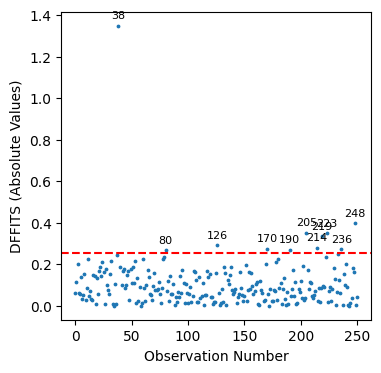

In [147]:
# DFFITS
bodyfat['dffits'] = res.get_influence().dffits[0]

fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFFITS (Absolute Values)")
plt.xlabel("Observation Number")
plt.scatter(bodyfat.index, 
            np.abs(bodyfat['dffits']), 
            s = 3)
threshold = 2 * np.sqrt(len(res.params) / len(bodyfat))
plt.axhline(y = threshold, 
            color = 'r', 
            linestyle = 'dashed')
influential_points = bodyfat[np.abs(bodyfat['dffits']) > threshold]
for i in influential_points.index:
    plt.annotate(str(i), 
                 (i, np.abs(bodyfat['dffits'][i])), 
                 textcoords="offset points", 
                 xytext=(0, 5), 
                 ha='center', 
                 fontsize=8)
plt.show()


Even after removing observation 39 and running the model with less variables, there appears to still be some outliers. Observation 38 which was not even an outlier originally appears to be now as well as 223 and 248. The assumption is not met.

#### 22. No multicollinearity (use the correlation matrix and variance inflation factors) [2 points]

In [148]:
# Variance Inflation Factors (VIF)
bodyfat_vifs = pd.DataFrame()
bodyfat_vifs['Feature'] = X_subset.columns[1:]
bodyfat_vifs['VIF'] = [vif(X, i) for i in range(1, len(X_subset.columns))]

print("Max = ", max(bodyfat_vifs['VIF']))
print("Mean = ", np.mean(bodyfat_vifs['VIF']))
bodyfat_vifs

Max =  18.559493265270934
Mean =  8.126355038364219


,Feature,VIF
0,weight,18.559493
1,abdom,2.331805
2,neck,3.487766


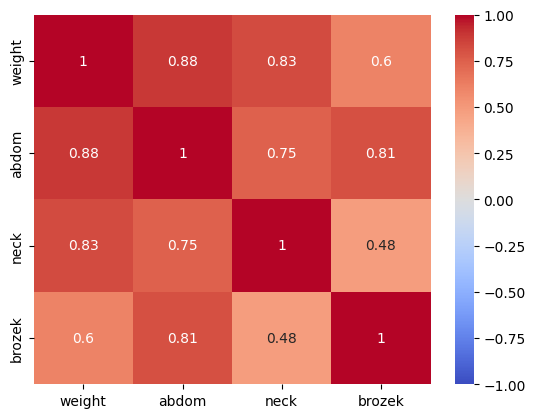

In [149]:
sns.heatmap(bodyfat[subset+['brozek']].corr(), 
            cmap = 'coolwarm',  # color pallete
            annot = True,  # adds the correlation values in the boxes
            vmin = -1,  # start color legend at -1
            vmax = 1,  # stop color legend at 1
            # mask = np.triu(bodyfat.corr()) # remove the upper half of the plot
            )  
plt.show()

The correlation coefficients are still really high. This isn't an issue for the value on abdomen vs brozek, but the strong correlation between all of the variables is not a good sign. The assumption is not met.

#### 23. Given the results from your model assumption checking, what would you do next to continue this analysis (you do not need to actually do it)? [1 point]


For the multicollinearity, I would apply techniques like LASSO or Elastic Net regularization to penalize and potentially remove correlated variables. These methods help select the most important predictors while reducing the impact of multicollinearity. I could check my work by looking at the VIF for each predictor to identify which variables are contributing the most to multicollinearity.

Although the influential points are not as clearly a damaging outlier as before, I would investigate the influential points identified by metrics with DFBETAS and DFFITS to see if they represent data entry errors, unusual circumstances, or genuine but extreme cases.



#### 24. Briefly summarize what you learned from this analysis *to a non-statistician*. Write a few sentences about (1) the purpose of this data set and analysis and (2) what you learned about this data set from your analysis. Write your response as if you were addressing a business manager (avoid using statistics jargon) and just provide the main take-aways. [2 points]

The purpose of this data set and analysis was to develop a simpler method for estimating body fat percentage without using the complex underwater weighing technique. By analyzing various body measurements, we aimed to create a reliable model that can predict body fat percentage accurately.

From the analysis, we learned that certain measurements, such as weight, abdominal circumference, and neck circumference, are strong predictors of body fat percentage. However, we also identified issues like multicollinearity, where some predictors are highly correlated with each other, which can affect the model's reliability. To address this and create a model that can be implemented to give a reliable measure of bodyfat percentage, we need to refine the model and ensure it provides accurate and stable predictions.